In [43]:
import numpy as np

from pysim.experiments.utility.rfid_helper import(
    calculate_probs, generation_interval, plot_probs
)
from pysim.models.rfid.params import default_params, inner_params, KMPH_TO_MPS_MUL
from pysim.experiments.utility.channel_helper import(
    find_zones, get_tag_rx
)

In [44]:
IMG_DIRECTORY = "rfid/multiple_tag/"
JSON_DIRECTORY = "../results/result_jsons/rfid/multiple_tag/"

In [45]:
def estimate_generation_interval(
    tags_amount: int,
    reading_zone: float,
    speed: float = default_params.speed) -> float:
    """
    Пересчитывает желаемое количество меток в зоне чтения в требуемый интервал генерации.

    На количество меток в зоне чтения влияет размер зоны чтения (зависит от канала),
    скорость движения и период генерации меток.

    Args:
        tags_amount: желаемое количество меток в зоне
        reading_zone: суммарная длина зон, где метка включена (в метрах)
        speed: скорость движения считывателя в км/ч

    Returns:
        Интервал генерации в секундах (временной промежуток между метками)
    """
    # Преобразуем скорость в м/с
    speed_mps = speed * KMPH_TO_MPS_MUL

    return reading_zone / (tags_amount * speed_mps)

In [46]:
# Вычисление длины зоны активности меток
ox_axis = np.linspace(
    - inner_params.geometry_params.initial_distance_to_reader,
    inner_params.geometry_params.initial_distance_to_reader,
    inner_params.geometry_params.grid_step
)
tag_accepted_power = [get_tag_rx(x, speed=0, t=0, power=default_params.power_dbm) for x in ox_axis]
tag_on_intervals = find_zones(ox_axis, tag_accepted_power, use_upper=True)
reading_zone = sum(end - start for start, end in tag_on_intervals)

In [47]:
TAGS_IN_READING_ZONE = (5, 15, 25)

tag_intervals = [
    estimate_generation_interval(n, reading_zone)
    for n in TAGS_IN_READING_ZONE
]
tag_period_params = [
    {"label": f"{n} меток", "generation_interval": (generation_interval, t)}
    for n, t in zip(TAGS_IN_READING_ZONE, tag_intervals)
]

In [48]:
q_variable = np.arange(0, 16, 1)
colllision_params_list = []

for tag_params_item in tag_period_params:
    colllision_params_list.append({
        'tari': default_params.tari,
        'encoding':  default_params.encoding,
        'tid_word_size': default_params.tid_word_size,
        'power': default_params.power_dbm,
        'num_tags': 250,
        'speed': default_params.speed,
        'reader_offset': default_params.reader_offset,
        'tag_offset': default_params.tag_offset,
        'altitude': default_params.altitude,
        'useadjust': True,
        "generation_interval": tag_params_item["generation_interval"],
        "label": tag_params_item["label"]
    })

In [49]:
key_name = lambda params: f"{params["label"]}"

In [50]:
_, collision_result = calculate_probs(
    variable="q",
    variable_values=q_variable,
    params_list=colllision_params_list,
    key_fn=key_name,
    use_json=True,
    save_results=False,
    json_directory=JSON_DIRECTORY,
    file_name="q_collision_adjust.json"
)

In [51]:
# plot_probs(
#     results_list=[collision_result],
#     labels_list=[key_name(params) for params in tag_period_params],
#     titles=["Зависимость вероятности от стартового Q\nпри использовнии алгоритма QueryAdjust"],
#     x_variable=q_variable,
#     x_label="Начальная величина параметра Q",
#     image_name="Collision probs QAdjust_0",
#     save_fig=True,
#     image_directory=IMG_DIRECTORY,
#     integer_labels=True
# )

In [52]:
# Переменная по оси абсцисс
# altitudes = np.arange(0.5, 7.5, 0.5)
altitudes = (1,2, 3, 4, 5, 6,)

# Каждый словарь в list - это набор входных данных для одной кривой
altitude_params_list = []
for tag_params_item in tag_period_params:
    altitude_params_list.append({
        'tari': default_params.tari,
        'encoding': default_params.encoding,
        'tid_word_size': default_params.tid_word_size,
        'power': default_params.power_dbm,
        'num_tags': 100,
        'speed': default_params.speed,
        'reader_offset': default_params.reader_offset,
        'tag_offset': default_params.tag_offset,
        'useadjust': default_params.useadjust,
        "generation_interval": tag_params_item["generation_interval"],
        "label": tag_params_item["label"],
        'q': default_params.q,
    })

In [53]:
key_name = lambda params: f"{params["label"]}"

_, time_altitude_results = calculate_probs(
    variable="altitude",
    variable_values=altitudes,
    params_list=altitude_params_list,
    key_fn=key_name,
    use_json=False,
    save_results=False,
    json_directory="test",
    file_name='altitude.json'
)

Моделирование по переменной altitude: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]


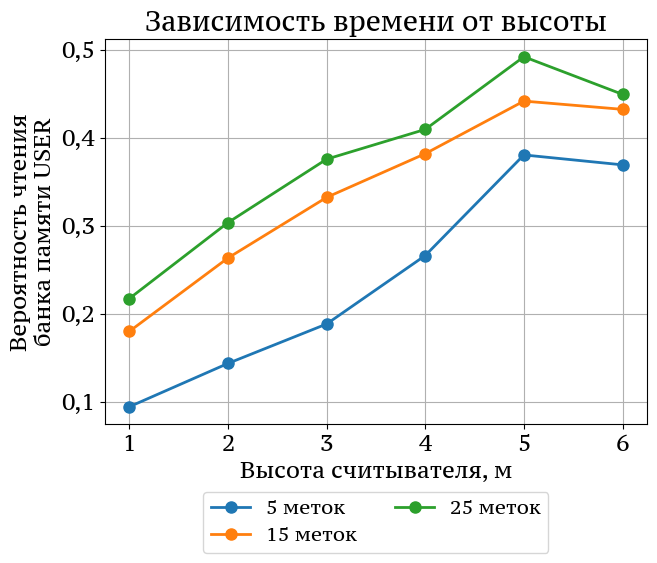

In [54]:
plot_probs(
    results_list=[time_altitude_results],
    labels_list=[key_name(params) for params in tag_period_params],
    titles=["Зависимость времени от высоты"],
    x_variable=altitudes,
    x_label="Высота считывателя, м",
    image_name="Altitude probs",
    save_fig=False,
    image_directory="",
)